In [1]:
import sympy as sym

from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import HTML
import IPython.display as dis

import matplotlib.pyplot as plt
import numpy as np
import mpmath as mp

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.special import jv, jn_zeros
from sympy import Derivative as D, Function as F

from functools import *

%matplotlib inline
plt.rcParams['animation.html'] = 'jshtml'

Tlmená vlnová rovnica:

In [2]:
r, theta, t, r1, c, a, u0 = sym.symbols("r theta t r1 c a u0", positive = True)
u = F('u')(r, theta, t)

# vlnova rovnica
ls = D(u, r, 2) + (1/r)*D(u, r, 1) + (1/r**2)*D(u, theta, 2)
rs = (1/c**2)*(D(u, t, 2) + 2*a*D(u, t, 1))
eq = sym.Eq(ls, rs)
eq

Eq(Derivative(u(r, theta, t), (r, 2)) + Derivative(u(r, theta, t), r)/r + Derivative(u(r, theta, t), (theta, 2))/r**2, (2*a*Derivative(u(r, theta, t), t) + Derivative(u(r, theta, t), (t, 2)))/c**2)

Funkcia počiatočnej deformácie membrány:

In [3]:
# pociatocna deformacia
A, sigma, r_u, theta_u = sym.symbols("A sigma r_u theta_u")
u_t0 = (A/(2*sym.pi*sigma))*sym.exp((-1/(2*sigma**2))*((r*sym.cos(theta)-r_u*sym.cos(theta_u))**2+(r*sym.sin(theta)-r_u*sym.sin(theta_u))**2))
u_t0

A*exp(-((r*sin(theta) - r_u*sin(theta_u))**2 + (r*cos(theta) - r_u*cos(theta_u))**2)/(2*sigma**2))/(2*pi*sigma)

Módy $0n$:

In [4]:
k_0n, a_0n, omega_mn, k_mn, a_mn, b_mn, m, n = sym.symbols("k_0n a_0n omega_mn k_mn a_mn b_mn m n", positive = True)

u_0n = (sym.besselj(0, k_0n*r/r1)*a_0n*sym.cos(sym.sqrt(omega_mn**2-a**2)*t)*sym.exp(-a*t))
u_0n

a_0n*exp(-a*t)*cos(t*sqrt(-a**2 + omega_mn**2))*besselj(0, k_0n*r/r1)

Módy $mn$:

In [5]:
u_mn = sym.besselj(m, k_mn*r/r1)*(a_mn*sym.cos(m*theta)+b_mn*sym.sin(m*theta))*sym.cos(sym.sqrt(omega_mn**2-a**2)*t)*sym.exp(-a*t)
u_mn

(a_mn*cos(m*theta) + b_mn*sin(m*theta))*exp(-a*t)*cos(t*sqrt(-a**2 + omega_mn**2))*besselj(m, k_mn*r/r1)

Funkcia výchylky ako suma všetkých módov:

In [6]:
u_sum = (1/2)*sym.Sum(u_0n,(n,1,sym.oo)) + sym.Sum(u_mn,(n,1,sym.oo),(m,1,sym.oo))
u_sum

0.5*Sum(a_0n*exp(-a*t)*cos(t*sqrt(-a**2 + omega_mn**2))*besselj(0, k_0n*r/r1), (n, 1, oo)) + Sum((a_mn*cos(m*theta) + b_mn*sin(m*theta))*exp(-a*t)*cos(t*sqrt(-a**2 + omega_mn**2))*besselj(m, k_mn*r/r1), (n, 1, oo), (m, 1, oo))

Overenie platnosti riešenia vlnovej rovnice pre daný mód:

In [7]:
# overenie platnosti riesenia vlnovej rovnice

def is_valid(u):
    ls = u.diff(r, r) + (1/r)*u.diff(r) + (1/r**2)*u.diff(theta, theta)
    rs = (1/c**2)*(u.diff(t, t) + 2*a*u.diff(t))
    
    if rs.equals(ls):
        print("Riešenie vlnovej rovnice je platné.")
    else:
        print("Riešenie vlnovej rovnice nie je platné.")

is_valid(u_mn.subs(omega_mn,c*k_mn/r1))

Riešenie vlnovej rovnice je platné.


Dosadenie konkrétnyc hodnôt gaussovej funkcie (počiatočnej deformácie):

In [8]:
u0_ = u_t0.subs([(sigma, 0.005), (A, 0.001)])
u0_

0.1*exp(-20000.0*(r*sin(theta) - r_u*sin(theta_u))**2 - 20000.0*(r*cos(theta) - r_u*cos(theta_u))**2)/pi

Funkcie pre výpočet konštánt $a_{mn}$ a $b_{mn}$. Integrály je nutné počítať numericky (využijeme knižnicu ``mpmath``):

In [9]:
# riesenie pomocou sympy (vypocetne narocne, trva aspon niekolko minut):
# a_mn = (2/(sym.pi*r1**2*(sym.besselj(m+1, k_mn))**2))*sym.integrate(r*sym.besselj(m, k_mn*r/r1)*u0*sym.cos(m*theta), (theta, 0, 2*sym.pi), (r, 0, r1))
# riesenie pomocou mpmath:
@lru_cache(maxsize=5) # cache pre zamedzenie duplicitneho vypoctu - funguje v Jupyter?
def get_a_mn(m, n, r_u_, theta1, r1, u0):
    k_mn = jn_zeros(m, n)[n-1]
    u0_subs = u0.subs([(theta_u, theta1), (r_u, r_u_)])
    int_lamb = sym.lambdify([r, theta], r*sym.besselj(m, k_mn*r/r1)*u0_subs*sym.cos(m*theta), modules=['mpmath'])
    integral = mp.quad(int_lamb, [0, r1], [0, 2*mp.pi]) # dvojity integral
    coeff = 2/(mp.pi*r1**2*(mp.besselj(m+1, k_mn))**2) # koeficient pred integralom
    return sym.Float(coeff * integral)

$a_{mn} = \frac{2}{\pi r_1^2 J_{m+1}^2(k_{mn})}\int_{0}^{r_1} \int_{0}^{2\pi}r J_m (\frac{k_{mn}r}{r_1}) u(r,\theta,0)\cos(m \theta)\,d\theta \,dr$, 
&nbsp;&nbsp;&nbsp;&nbsp;kde $u(r,\theta,0)$ je funkcia počiatočnej deformácie

In [10]:
# b_mn_ = (2/(sym.pi*(sym.besselj(m+1, k_mn))**2))*sym.integrate(r*sym.besselj(m, k_mn*r/r1)*u0*sym.sin(m*theta), (theta, 0, 2*sym.pi), (r, 0, r1))
@lru_cache(maxsize=5) # cache pre zamedzenie duplicitneho vypoctu - funguje v Jupyter?
def get_b_mn(m, n, r_u_, theta1, r1, u0):
    if (m == 0):
        return 0
    k_mn = jn_zeros(m, n)[n-1]
    u0_subs = u0.subs([(theta_u, theta1), (r_u, r_u_)])
    int_lamb = sym.lambdify([r, theta], r*sym.besselj(m, k_mn*r/r1)*u0_subs*sym.cos(m*theta), modules=['mpmath'])
    integral = mp.quad(int_lamb, [0, r1], [0, 2*mp.pi]) # dvojity integral
    coeff = 2/(mp.pi*(mp.besselj(m+1, k_mn))**2) # koeficient pred integralom
    return sym.Float(coeff * integral)

$b_{mn} = \frac{2}{\pi J_{m+1}^2(k_{mn})}\int_{0}^{r_1} \int_{0}^{2\pi}r J_m (\frac{k_{mn}r}{r_1}) u\sin(m \theta)\,d\theta \,dr$,
&nbsp;&nbsp;&nbsp;&nbsp;kde $u(r,\theta,0)$ je funkcia počiatočnej deformácie

Funkcia pre výpočet aproximácie funkcie výchylky (pre prvých $N(N-1)$ módov):

In [11]:
def get_u(N, a_, c_, r1_, u0_, theta_u_, r_u_):
    u_0n_sum = 0
    u_mn_sum = 0
    for i in range(1, N):
        a_0n_ = get_a_mn(0, i, r_u_, theta_u_, r1_, u0_)
        k_0n_ = jn_zeros(0, i)[i-1]
        omega_0n_ = c_*k_0n_/r1_
        #u_0n_sum += a_0n*sym.exp(-a*t)*sym.cos(t*sym.sqrt(-a**2+omega_0n**2))*sym.besselj(0, k_0n*r/r1)
        u_0n_sum += u_0n.subs([(n, i), (a_0n, a_0n_), (a, a_), (c, c_), (r1, r1_), (u0, u0_), (theta_u, theta_u_), (k_0n, k_0n_), (omega_mn, omega_0n_)])
    for i in range(1, N):
        for j in range(1, N):
            a_mn_ = get_a_mn(i, j, r_u_, theta_u_, r1_, u0_)
            b_mn_ = get_b_mn(i, j, r_u_, theta_u_, r1_, u0_)
            k_mn_ = jn_zeros(i, j)[j-1]
            omega_mn_ = c_*k_mn_/r1_
            #u_mn_sum +=  (a_mn*sym.cos(i*theta)+b_mn*sym.sin(i*theta))*sym.exp(-a*t)*sym.cos(t*sym.sqrt(-a**2+omega_0n**2))*sym.besselj(0, k_0n*r/r1)
            u_mn_sum += u_mn.subs([(m, i), (n, j), (a_mn, a_mn_), (b_mn, b_mn_), (a, a_), (c, c_), (r1, r1_), (u0, u0_), (theta_u, theta_u_), (k_mn, k_mn_), (omega_mn, omega_mn_)])
    return 0.5*u_0n_sum + u_mn_sum

Definícia hodnôt fyzikálnych veličín:

In [12]:
# koeficient tlmenia
a1 = 4 # s-1
# povrchove napatie
P0 = 1500 # N*m-1
# plosna hustota
sigma1 = 0.26 # kg*m-2
# rychlost sirenia vlny
c1 = np.sqrt(P0/sigma1) # m*s-1
# polomer membrany
r2 = 0.35 # m

Výber miesta úderu a výpočet $u(r,\theta,t)$:
-------------------------

Posuvníkom ``r1`` vyberieme vzdialenosť bodu úderu od stredu a následne vypočítame funkciu výchylky kliknutím na tlačítko. Ďalšie bunky je potrebné spustiť ručne. 

In [13]:
plt.rcParams['figure.figsize'] = [12, 8]

theta_u_ = 0

N = 5 # N*(N−1) urcuje pocet modov pouzitych k aproximacii 

@interact(r1=(0.0,r2,0.05))
def u0_graph(r1 = 0):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    # funkcia pre vizualizaciu pociatocnej deformacie
    f = sym.lambdify([r, theta], u0_.subs([(theta_u, theta_u_), (r_u, r1)]), modules=['scipy'])
    
    # vytvorenie os, mesh
    r_space = np.linspace(0, r2, 50)
    p_space = np.linspace(0, 2*np.pi, 50)
    R_mesh, P_mesh = np.meshgrid(r_space, p_space)
    U = f(R_mesh, P_mesh).real

    # prevedenie do kartezianskeho suradnicoveho systemu
    X, Y = R_mesh*np.cos(P_mesh), R_mesh*np.sin(P_mesh)

    # vykreslenie grafu
    ax.plot_surface(X, Y, U, cmap=plt.cm.viridis)

    # ohranicenie osi vychylky, popisanie os
    ax.set_zlim(-0.1, 0.1)
    ax.set_xlabel(r'$x$ [m]', fontsize=14)
    ax.set_ylabel(r'$y$ [m]', fontsize=14)
    ax.set_zlabel(r'$u(x, y, t)$ [m]', fontsize=14)

    plt.show()
    
    global r_u_
    r_u_ = r1
    
button = widgets.Button(description='Vypocitat funkciu vychylky')
def on_button_clicked(_):
    print("pocitam... (moze trvat cca minutu)")
    global u_approx
    # aproximacia funkcie vychylky na zaklade zvoleneho bodu uderu
    u = get_u(N, a1, c1, r2, u0_, theta_u_, r_u_)
    print(u)
    u_approx = sym.lambdify([r, theta, t], u,  modules=[{'besselj': jv}, 'scipy'])
button.on_click(on_button_clicked)
button

interactive(children=(FloatSlider(value=0.0, description='r1', max=0.35, step=0.05), Output()), _dom_classes=(…

Button(description='Vypocitat funkciu vychylky', style=ButtonStyle())

pocitam... (moze trvat cca minutu)
(-1.56114713188164e-5*sin(theta) - 0.00012744058219442*cos(theta))*exp(-4*t)*cos(2207.79745079987*t)*besselj(1, 29.0670518144649*r) + (-2.44130248303642e-6*sin(theta) - 1.99289998615218e-5*cos(theta))*exp(-4*t)*cos(1522.48634624128*t)*besselj(1, 20.0445333423303*r) + (1.06416565873654e-5*sin(theta) + 8.68706660193093e-5*cos(theta))*exp(-4*t)*cos(2891.44594867681*t)*besselj(1, 38.0676912466121*r) + (1.09219169706701e-5*sin(theta) + 8.9158505883021e-5*cos(theta))*exp(-4*t)*cos(831.530267621869*t)*besselj(1, 10.94773134345*r) + (-1.81820295173685e-5*sin(2*theta) - 0.000148424730754028*cos(2*theta))*exp(-4*t)*cos(2521.68338343842*t)*besselj(2, 33.1995462061402*r) + (7.42462306230709e-7*sin(2*theta) + 6.0609167855568e-6*cos(2*theta))*exp(-4*t)*cos(3210.94954641017*t)*besselj(2, 42.274147949575*r) + (4.83288067750947e-6*sin(2*theta) + 3.94520871633426e-5*cos(2*theta))*exp(-4*t)*cos(1826.66872830613*t)*besselj(2, 24.049268972571*r) + (1.33317649696762e-5*sin

Animácia vĺn na membráne pre vybrané miesto úderu:
--------------------------

In [18]:
try:
    u_approx
except NameError:
    print("Funkcia výchylky nedefinovaná.")
    print("Je nutné vypočítať funkciu výchylky v predchodzej bunke a následne znovu spustiť túto bunku.")
else:
    plt.rcParams['figure.figsize'] = [12, 8]
    fps = 8 # pocet snimok za sekundu
    frn = 20 # pocet snimok

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # vytvorenie os, mesh
    r_space = np.linspace(0, r2, 50)
    p_space = np.linspace(0, 2*np.pi, 50)
    R_mesh, P_mesh = np.meshgrid(r_space, p_space)

    t_max = 2 # s

    U = np.zeros((50, 50, frn))
    for i in range(frn):
        U[:,:,i] = u_approx(R_mesh, P_mesh, (t_max/frn)*i)

    # prevedenie do kartezianskeho suradnicoveho systemu
    X, Y = R_mesh*np.cos(P_mesh), R_mesh*np.sin(P_mesh)

    def update_plot(frame_number, zarray, plot):
        plot[0].remove()
        plot[0] = ax.plot_surface(X, Y, U[:,:,frame_number], cmap=plt.cm.viridis)

    # ohranicenie osi vychylky, popisanie os
    ax.set_zlim(-0.0005, 0.0005)
    ax.set_xlabel(r'$x$ [m]', fontsize=14)
    ax.set_ylabel(r'$y$ [m]', fontsize=14)
    ax.set_zlabel(r'$u(x, y, t)$ [m]', fontsize=14)
    
    plot = [ax.plot_surface(X, Y, U[:,:,0], color='0.75', rstride=1, cstride=1)]
    ani = animation.FuncAnimation(fig, update_plot, frames=frn, fargs=(U, plot), interval=1000/fps)
    plt.close()
    dis.display(ani)

Frekvenčné zastúpenie:
------------------------

Amplitúda konkrétneho módu:

In [15]:
amp_mn = sym.sqrt(a_mn**2 + b_mn**2)
amp_mn

sqrt(a_mn**2 + b_mn**2)

Frekvencia konkrétneho módu:

In [16]:
f_mn = sym.sqrt((c*k_mn/r1)**2-a**2)
f_mn

sqrt(-a**2 + c**2*k_mn**2/r1**2)

Výpočet amplitúd a frekvencií jednotlivých módov pre našu aproximáciu a zobrazenie aproximácie frekvenčného spektra:

Po zmene bodu úderu je potrebné bunku znova spustiť.

(výpočet môže chvíľu trvať)

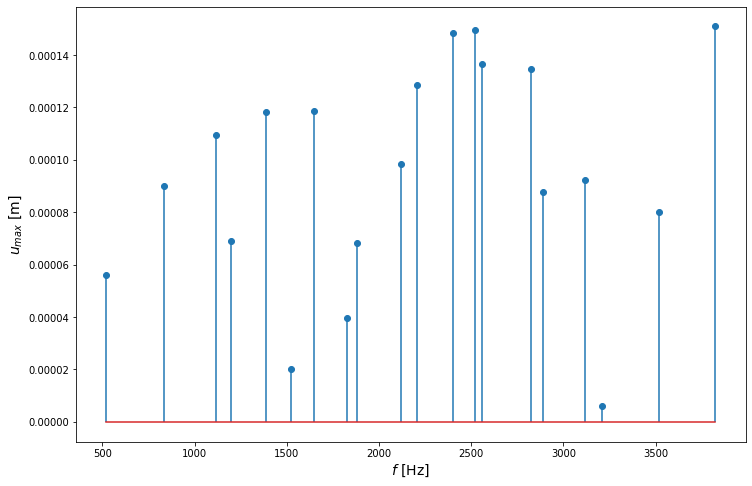

In [20]:
amps = []
freqs = []
for i in range(0, N):
    for j in range(1, N):
        k_mn_ = jn_zeros(i, j)[j-1]
        amps.append(amp_mn.subs([(a_mn, get_a_mn(i, j, r_u_, theta_u_, r2, u0_)), (b_mn, get_b_mn(i, j, r_u_, theta_u_, r2, u0_))]).evalf())
        freqs.append(sym.re(f_mn.subs([(a, a1), (c, c1), (k_mn, k_mn_), (r1, r2)])))

plt.stem(freqs, amps, use_line_collection=True)
plt.xlabel(r"$f$ [Hz]", fontsize=14)
plt.ylabel(r"$u_{max}$ [m]", fontsize=14)
plt.show()

Môžeme si všimnúť, že čím je bod úderu ďalej od stredu, tým hustejšie je spektrum, a tým viac sa prejavujú inharmonické zložky. Módy $0n$ majú kváziharmonický charakter - pri údere do stredu sa prejavujú len tieto módy. Frekvenčné pásmo je úzke, pretože počítame aproximáciu len malého počtu módov.